In [1]:
from optical_lattice import GeneratedLatticeImage
import numpy as np
import matplotlib.pyplot as plt

In [2]:
M = 10 #Number of pixels per lattice site
N = 30 #Number of lattice sites along each axis
CCD_resolution = 1024
lattice_origin = (400,600)
N_atom = 700 #Number of atoms to be randomly placed
N_photon = 200 #Number of photons atoms fluoresce
std = 1 #Width of the normal distribution that counts are sampled from
#When checking the position of counts, use a smaller number for N_backg like 300 and 10 for lam_backg
N_backg = 3000 #Number of samples drawn from the Poisson distribution for the background noise
lam_backg = 200 #Expectation interval of the Poisson dark count event

In [3]:
lattice_image = GeneratedLatticeImage(
    N=N,
    M=M,
    N_atom=N_atom,
    N_photon=N_photon,
    CCD_resolution = CCD_resolution,
    lattice_origin = lattice_origin,
    std=std,
    N_backg=N_backg, 
    lam_backg=lam_backg
)

In [4]:
# lattice_image.plot()

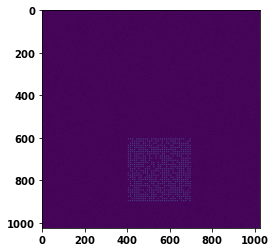

In [5]:
plt.imshow(lattice_image.pixel_grid)

In [6]:
atom_location = np.random.choice(np.arange(N*N), N_atom, replace=False) #pick atom position randomly from NxN array

actual_lattice = np.zeros((N,N))
atom_location_index = np.unravel_index(atom_location,(N,N))
temp0 = atom_location_index 
#Store actual occupation of the atoms for future comparison with the inferred one
for x,y in zip(atom_location_index[0],atom_location_index[1]):
    actual_lattice[N-y-1,x] = 1

# atom_location_index = (atom_location_index - np.ones((2, N_atom))*((N-1)/2)) * M #convert the atom location number to x,y atom location index
temp = atom_location_index
atom_location_index = atom_location_index + np.zeros((2, N_atom))*M*N #convert the atom location number to x,y atom location index
temp2 = atom_location_index
atom_location_index = atom_location_index*M + M/2
x_index = atom_location_index[0,:] #atoms x location
y_index = N*M - atom_location_index[1,:] #atoms y location

# lims = np.arange(0, (N+1)*M, M) - (N*M)/2 #locations of the edges of each lattice site

# print(actual_lattice)

pixel_grid = np.zeros((CCD_resolution,CCD_resolution))

#For each atom sample photons from a Gaussian centered on the lattice site, combine the x,y positions of the counts
x_loc = np.array([])
y_loc = np.array([])
for i in range(N_atom):
    xx, yy = np.random.multivariate_normal([x_index[i], y_index[i]], [[std, 0], [0, std]], N_photon).T #at each atom location sample N_photons from a Gaussian
    # Round and cast photon positions to respect pixel postions 
    xx = np.rint(xx).astype(int) + lattice_origin[0]
    yy = np.rint(yy).astype(int) + lattice_origin[1]
    x_loc = np.concatenate((x_loc, xx)) #combine the sampled x-locations for each atom
    y_loc = np.concatenate((y_loc, yy)) #combine the sampled y-locations for each atom
    
#Generate dark counts which is the background noise of the camera. Combine dark photon locations with scattered photon locations.
CCD_x = np.arange(0, CCD_resolution, 1) #x-pixel locations
CCD_y = np.arange(0, CCD_resolution, 1) #y-pixel locations
dark_count = np.random.poisson(lam_backg, N_backg) #create dark counts sampling from a Poisson distribution, this gives numbers corresponding to number of dark counts
dark_count_location_x = np.random.choice(CCD_x, np.sum(dark_count), replace=True) #pick a random x location for the dark counts
dark_count_location_y = np.random.choice(CCD_y, np.sum(dark_count), replace=True) #pick a random y location for the dark counts

x_loc = np.concatenate((x_loc, dark_count_location_x)).astype(int) #combine the sampled x-locations from atoms and dark counts
y_loc = np.concatenate((y_loc, dark_count_location_y)).astype(int) #combine the sampled y-locations from atoms and dark counts

#convert counts to intensity values for each pixel

for x,y in zip(x_loc,y_loc):
    if(x<CCD_resolution and y<CCD_resolution and x>0 and y>0):
        # pixel_grid[CCD_resolution-y-1,x] += 1
        pixel_grid[y,x] += 1
print(pixel_grid.max())
#Shift and scale counts to mimic data from CCD
# pixel_grid *= 5000/pixel_grid.max()
# pixel_grid += 600

46.0


In [7]:
# coords = np.zeros((2,len(dark_count_location_y)),dtype=int)
# coords[0,:] = dark_count_location_x
# coords[1,:] = dark_count_location_y
# coords = coords.T
# plt.plot(np.unique(coords,return_counts=True,axis = 0)[1],'.')

In [8]:
pixel_grid.max()

46.0

0.0

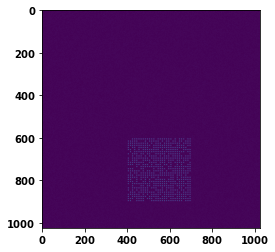

In [9]:
from matplotlib.colors import LogNorm
plt.imshow(pixel_grid)
np.min(pixel_grid)

In [10]:
# useful for checking that each count sits in the middle of a pixel
# isolates a particular part of the generated photon counts to more
# easily see each pixel
def grid_plot(num_sites=1):
        '''Plot the image (collected photons) on the camera.'''
        fig = plt.figure(figsize=(8, 8), dpi=100)
        ax = fig.add_subplot(1,1,1)
        xlims = (lattice_origin[0],lattice_origin[0]+N*M)
        ylims = (lattice_origin[1],lattice_origin[1]+N*M)
        coords = np.zeros((2,len(x_loc)),dtype=int)
        coords[0,:] = x_loc
        coords[1,:] = y_loc
        coords = coords.T
        lattice_coords = coords[(coords[:,0]>xlims[0])*(coords[:,0]<xlims[1])*(coords[:,1]>ylims[0])*(coords[:,1]<ylims[1]),:]
        reduced_lattice_coords = lattice_coords[(lattice_coords[:,0] < (num_sites*M + xlims[0]))*(lattice_coords[:,1] < (num_sites*M + ylims[0]))]
        im = plt.plot(reduced_lattice_coords.T[0], reduced_lattice_coords.T[1], 'ko', markersize=1,alpha=0.25) #plot counts
        
        ax.set_xticks(np.arange(-0.5-1*M, (num_sites+1)*M+0.5, 1) + xlims[0]) #vertical lines as visual aid
        ax.set_yticks(np.arange(-0.5-1*M, (num_sites+1)*M+0.5, 1) + ylims[0]) #horizontal lines as visual aid
        ax.grid(True, color="black")
        ax.invert_yaxis()

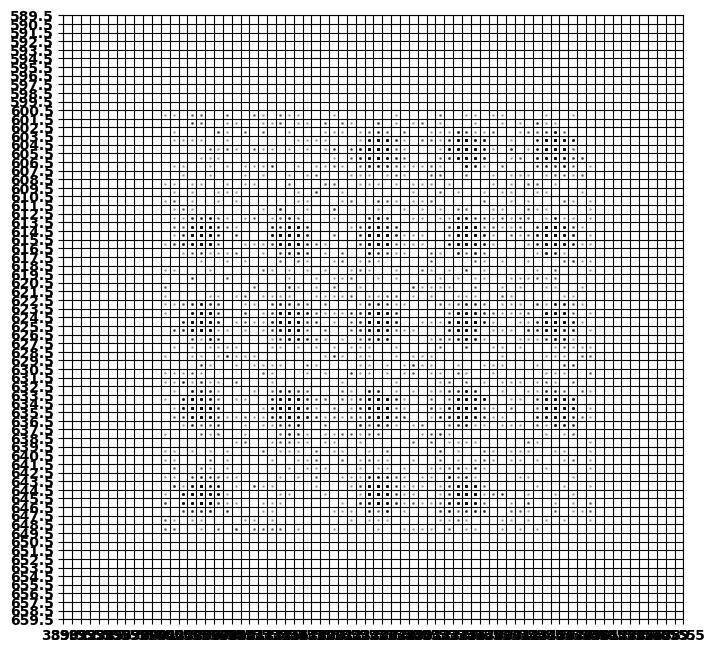

In [11]:
grid_plot(num_sites = 5)